Progress So far:

We gathered some useful data sets from:

GenAge http://genomics.senescence.info/genes/

Cell Map(Yeast Genome): https://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/

Cell Map.org: https://thecellmap.org/

Data set : http://math.bu.edu/people/kolaczyk/datasets.html

Used the orthologs model to find similar genes between yeast, mice, worms, fruit flies

** TO DO **

* Need to look up Managbanag et al. (2008) "Shortest-path ..." study

* check out gene length as a way to classify

* Need to formalize patterns for longevity genes/types --> steps in graph could indicate tree like structure

* mouse data connected via gene symbol

* look into using variance on specific longevity types

In [1]:
from copy import deepcopy
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
from scipy import stats
%matplotlib inline

**Load initial files**

- The 'yeast_genage_models_export.tsv' file contains the the genes which have been linked to longevity.

- The 'genage_models_orthologs_export.tsv' file contains orthologs from other species. 

Using .info() and .head() to take a look at type of data and formatting.

In [2]:
yeast_file = 'yeast_genage_models_export.tsv'
homologous_files = ['genage_models_orthologs_export.tsv']#, 'worm_genage_models_orthologs_export.tsv',
                    #'fly_genage_models_orthologs_export.tsv', 'mouse_genage_models_orthologs_export.tsv']
df_yeast = pd.read_csv(yeast_file, sep=r'\t', engine='python')
df_h = pd.read_csv(homologous_files[0], sep=r'\t', engine='python')
df_h.head(20)

,Species,Symbol,Entrez ID,Model Organism,Model Organism Symbol,Model Organism Entrez ID
0,Saccharomyces cerevisiae,SNF1,852088,Caenorhabditis elegans,aak-2,181727
1,Saccharomyces cerevisiae,SIP2,852664,Caenorhabditis elegans,aakb-1,181492
2,Saccharomyces cerevisiae,SIP2,852664,Caenorhabditis elegans,aakb-2,176552
3,Saccharomyces cerevisiae,MUP1,852946,Caenorhabditis elegans,aat-8,185079
4,Saccharomyces cerevisiae,ACO1,851013,Caenorhabditis elegans,aco-2,176121
5,Saccharomyces cerevisiae,FAT1,852329,Caenorhabditis elegans,acs-20,178190
6,Saccharomyces cerevisiae,FAA2,856734,Caenorhabditis elegans,acs-5,176785
7,Saccharomyces cerevisiae,SCH9,856612,Caenorhabditis elegans,akt-1,179424
8,Saccharomyces cerevisiae,AAC3,852380,Caenorhabditis elegans,ant-1.1,176773
9,Saccharomyces cerevisiae,APS3,853429,Caenorhabditis elegans,aps-3,171691


In [3]:
df_yeast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gene ID                  1185 non-null   int64  
 1   Entrez Gene ID           1185 non-null   int64  
 2   Gene Symbol              1185 non-null   object 
 3   Gene Name                1185 non-null   object 
 4   Organism                 1185 non-null   object 
 5   Unigene ID               0 non-null      float64
 6   Ensembl ID               1086 non-null   object 
 7   UniProt ID               0 non-null      float64
 8   Alias                    502 non-null    object 
 9   Lifespan Effect          1177 non-null   object 
 10  Phenotype Description    1185 non-null   object 
 11  Longevity Influence      1172 non-null   object 
 12  Max Lifespan Change      23 non-null     float64
 13  Avg Lifespan Change      634 non-null    float64
 14  Method                  

In [4]:
df_yeast.head(30)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1553,852380,AAC3,ADP/ATP Carrier,Saccharomyces cerevisiae,NaN,YBR085W,NaN,ANC3,increase,Replicative lifespan increased by 15% in the a...,anti,NaN,15.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
1,1393,855581,AAH1,Adenine AminoHydrolase,Saccharomyces cerevisiae,NaN,YNL141W,NaN,NaN,increase,Mean chronological lifespan increased in the a...,anti,NaN,NaN,Deletion,"2501: Matecic et al. (2010) ""A microarray-base..."
2,1612,853755,AAT1,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YKL106W,NaN,NaN,increase,Replicative lifespan increased by 25%,pro,NaN,25.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
3,1613,850714,AAT2,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YLR027C,NaN,ASP5,increase,Replicative lifespan increased by 15%,pro,NaN,15.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
4,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 20% in the a...,anti,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
5,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
6,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 30% in the a...,anti,NaN,30.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
7,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
8,1507,852925,ACB1,Acyl-CoA-Binding,Saccharomyces cerevisiae,NaN,YGR037C,NaN,NaN,increase,Mean replicative lifespan increased in the alp...,anti,NaN,NaN,Deletion,"2500: Fabrizio et al. (2010) ""Genome-wide scre..."
9,1914,852266,ACH1,Ach1p,Saccharomyces cerevisiae,NaN,NaN,NaN,NaN,decrease,Deletion of ACH1 reduces chronological lifespan.,fitness,NaN,NaN,Deletion,"3522: Eisenberg et al. (2014) ""Nucleocytosolic..."


Get the relevant values for our Network

In [5]:
longevity_id = [x for x in df_yeast['Ensembl ID']]
longevity_method = [x for x in df_yeast['Method']]
longevity_id_dict = dict(zip(longevity_id, longevity_method))


del_list = []
for i in range(len(longevity_id)):
    if longevity_method[i] == 'Deletion':
        del_list.append(longevity_id[i])
print(len(del_list))

1078


In [6]:
#Make graph with color coded nodes 
def set_color(n):
    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc']
    if n in longevity_id_dict:
        #if longevity_id_dict[n] == 'deletion':
        #    # green
        #return colors[1]
        #elif longevity_id_dict[n] == 'anti':
        #    # red
            return colors[0]
        #elif longevity_id_dict[n] == 'fitness':
        #    # orange
        #    return colors[3]
        #elif longevity_id_dict[n] == 'unclear':
        #    return colors[2]
        #else:
        #    return colors[2]
    else:
        return colors[2]
# Ohnologs = gene pairs within the same genome that were produced as the result of a whole genome 

In [7]:
# Add interaction edges

G = nx.Graph()
        
gene_quick_lookup = {} 
id_int = 0

interactions = 'ppi/ppi.txt'
with open(interactions, 'r') as f:
    for line in f:
        i = line.split('\t')
        if i[0].strip() not in gene_quick_lookup:
            #continue
            gene_quick_lookup[i[0].strip()] = id_int
            node_color = set_color(i[0].strip())
            G.add_node(id_int, name=i[0].strip(), color=node_color)
            id_int +=1
        elif i[1].strip() not in gene_quick_lookup:
            #continue
            gene_quick_lookup[i[1].strip()] = id_int
            node_color = set_color(i[1].strip())
            G.add_node(id_int, name=i[1].strip(), color = node_color)
            id_int +=1
        elif (gene_quick_lookup[i[0].strip()], gene_quick_lookup[i[1].strip()]) not in G.edges():
            G.add_edge(gene_quick_lookup[i[0].strip()], gene_quick_lookup[i[1].strip()])
print(G.number_of_nodes())


5092


In [8]:
#Add further depth

with open('saccharomyces_cerevisiae_R64-2-1_20150113.gff', 'r') as f:
    for line in f:
        if '#' in line:
            continue
        else:
            i = line.split('\t')
            if len(i)<2:
                continue
            c = i[0].strip()
            #if c != 'chrI' and c != 'chrII' and c != 'chrIII':# and c != 'chrIV':
            #    continue
            node_type = i[2].strip()
            if node_type in ['gene', 'CDS', 'mRNA']:
                deets = i[8].split(';')
                g_id = None
                parent = None
                for x in deets:
                    if 'ID' in x:
                        g_id = x.replace('ID=','').strip()
                    elif 'Name' in x:
                        g_id = x.replace('Name=', '').strip()
                    if 'Parent' in x:
                            parent = x.replace('Parent=','').strip()
                if g_id is not None:
                    if g_id in gene_quick_lookup:
                        G.nodes[gene_quick_lookup[g_id]].update({'chromosome': c, 'node_type': node_type})
                        if parent is not None:
                            if parent in gene_quick_lookup:
                                G.nodes[gene_quick_lookup[parent]].update({'chromosome':c, 'node_type': node_type})
                                G.add_edge(gene_quick_lookup[g_id], gene_quick_lookup[parent])

In [9]:
with open('summary.csv', 'r') as f:
    for line in f:
        if 'input' in line:
            continue
        else:
            line_split = line.split('" "')
            if len(line_split) >=9:
                gene_type = line_split[9].lower().strip()
                gene_length = line_split[6]
                try:
                    gene_length = int(line_split[6])
                except:
                    gene_length = 1555.6
                yeast_id = line_split[0].replace('"','')
                if yeast_id in gene_quick_lookup:
                    G.nodes[gene_quick_lookup[yeast_id]].update({'gene_length': gene_length})
                

In [10]:
for n in G.nodes():
    if 'color' not in G.nodes[n]:
        G.nodes[n]['color'] = set_color(G.nodes[n]['name'])
        
    
    if 'gene_length' not in G.nodes[n]:
        G.nodes[n]['gene_length'] = 1555.6
        
    if 'chromosome' not in G.nodes[n]:
        G.nodes[n]['chromosome'] = 'unk'

In [12]:
#longevity_subgraphs = []
#other_subgraphs = []
print(G.number_of_nodes())

connected = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
#for c in connected: 
#    if len(c) > 1:
#        for x in c:
#            longevity_subgraphs.append(x)
#G_main = G.subgraph(longevity_subgraphs).copy()
#one large graph analysis
#G_main = G.copy()
G_main = G.subgraph(connected[0]).copy()
print(G_main.number_of_nodes())
print(G_main.number_of_edges())
#for n in G_main.nodes(): 
#    if 'gt' not in G_main.nodes[n]:
#        G_main.nodes[n]['gt'] = 'unk'
print(G_main.number_of_nodes())


5092
4322
26098
4322


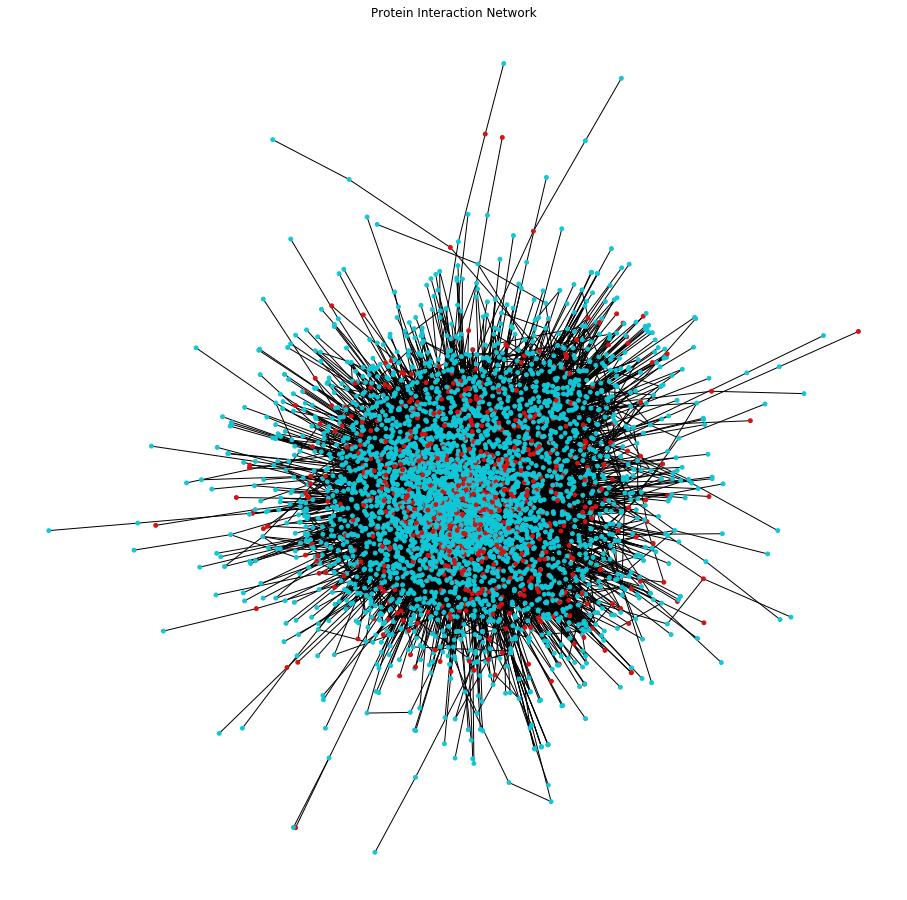

In [198]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network')
nx.draw(G_main, pos=nx.spring_layout(G_main),
        node_size=15, 
        node_color=[G_main.nodes[n]['color'] for n in G_main.nodes()], ax=ax)
plt.show()

**Network Facts**


This network is made of 3 things:

- 1: gene interaction
- 2: gene expression
- 3: Ohnologs: gene pairs within the same genome that were produced as the result of a whole genome duplication

Just from visual obeservation:
It appears that no longevity noes are on the periphery. So they should have min degree of 2. (verify) 

In [13]:
def calculate_DegreezScore(G,i):
    # This function calculates the degree z-score of node i, given graph G
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : i, a node in G
    # output : z_i, the degree z-score
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 5 lines, plus return)
    xbar = (2* G.number_of_edges())/G.number_of_nodes()
    sum_val = 0
    for n in G.nodes:
        sum_val += (G.degree(n) - xbar)**2
    sigma = np.sqrt(sum_val/(G.number_of_nodes()-1))
    return ((G.degree(i)-xbar)/sigma)

In [14]:
def calculate_Participation(G,z,i):
    # This function calculates the participation coefficient of node i, given graph G and partition z
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes
    #        : i, a node in G
    # output : P_i, the participation coefficient
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 9 lines, plus return)
    
    groups = {}
    sum_val = 0
    for n in G.neighbors(i):
        if z[n] not in groups:
            groups[z[n]] = 1
        else:
            groups[z[n]] +=1
    for g in groups:
        sum_val += (groups[g]/G.degree(i))**2
    return 1- sum_val

for n in G_main.nodes:
    if 'chromosome' not in G_main.nodes[n]:
        G_main.nodes[n]['chromosome'] = 'unk'
z = {x: G_main.nodes[x]['chromosome'] for x in G_main.nodes()}

In [15]:
n = G_main.number_of_nodes()
m = G_main.number_of_edges()
k = (2*m)/n
C = nx.transitivity(G_main)

# from PS 3 
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)
    
    sum = 0
    for node in G.nodes():
        sum += single_source(G, node)
    return sum/G.number_of_nodes()
    
def single_source(G, node):
    # sssp is the list of all shortest paths from a source node. It will not include infite paths. It will include 0 paths.
    sssp = dict(nx.single_source_shortest_path(G, node))
    
    # z is the number of non-infinite and non-zero pairwise distances being summed over. 
    z = 0
    # the sum of all path lengths which are non-zero and non-infinite
    sum_dist = 0
    
    for target in sssp:
        # This will remove and paths with len 0 from the apsp dict.
        if target != node:
            # using the -1 will give accurate path lengths rather than node count.
            sum_dist += len(sssp[target]) -1
            z += 1
    # return the mean of the shortest pairwise distances
    return sum_dist/z

zscore = []
avg_gene_length = []
for i in G_main.nodes():
    try: 
        avg_gene_length.append(int(G_main.nodes[i]['gene_length']))
    except:
        continue
    zscore.append(calculate_DegreezScore(G_main, i))
zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)
#gl_std = np.std(avg_gene_length)
mean_gl = np.mean(avg_gene_length)

ellmean = compute_MGD(G_main)


print("Overall")
print('Number of nodes: {}'.format(n))
print('Number of edges: {}'.format(m))
print('Average Degree: {}'.format(k))
print('Clustering coefficient: {}'.format(C))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Average Degree Z Score: {}'.format(mean_zscore))
#print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(mean_gl))

Overall
Number of nodes: 4322
Number of edges: 26098
Average Degree: 12.076816288755206
Clustering coefficient: 0.11918607898376045
Mean Geodesic Distance: 3.6824879753334874
Average Degree Z Score: 0.0
Avg gene length of 1595.245719574271


In [16]:
overall_longevity_nodes = [n for n in G_main.nodes() if G_main.nodes[n]['color'] != '#11c6d6']
non_longevity_nodes = [n for n in G_main.nodes() if n not in overall_longevity_nodes]
edges = 0
for n in overall_longevity_nodes:
    edges += G_main.degree(n)
ell = 0 
for n in overall_longevity_nodes:
    ell += single_source(G_main, n)
ellmean = ell/len(overall_longevity_nodes)

zscore = []
l_avg_gene_length = []
for i in overall_longevity_nodes:
    try:
        l_avg_gene_length.append(int(G_main.nodes[i]['gene_length']))
    except:
        continue
    zscore.append(calculate_DegreezScore(G_main, i))
#zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)
#gl_std = np.std(l_avg_gene_length)
mean_gl = np.mean(l_avg_gene_length)
  
print("All Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(overall_longevity_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(overall_longevity_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Mean Degree Z Score: {}'.format(mean_zscore))
#print('Avergae Degree Z Score: {}'.format(mean_zscore))
#print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(mean_gl))

All Longevity Nodes
Number of Longevity Nodes: 656
Number of in/out edges: 7349
Average Degree: 11.202743902439025
Mean Geodesic Distance: 3.654563857169463
Mean Degree Z Score: -0.052184116185933195
Avg gene length of 1658.5137195121952


In [17]:
edges = 0
for n in non_longevity_nodes:
    edges += G_main.degree(n)
ell = 0 
for n in non_longevity_nodes:
    ell += single_source(G_main, n)
ellmean = ell/len(non_longevity_nodes)

zscore = []
n_avg_gene_length = []
for i in non_longevity_nodes:
    try:
        n_avg_gene_length.append(G_main.nodes[i]['gene_length'])
    except: 
        continue
    zscore.append(calculate_DegreezScore(G_main, i))
#zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)
#gl_std = np.std(n_avg_gene_length)
mean_gl = np.mean(n_avg_gene_length)
    
print("Non Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(non_longevity_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(non_longevity_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Average Degree Z Score: {}'.format(mean_zscore))
#print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(mean_gl))

Non Longevity Nodes
Number of Longevity Nodes: 3666
Number of in/out edges: 44847
Average Degree: 12.233224222585925
Mean Geodesic Distance: 3.6874847624353997
Average Degree Z Score: 0.009337910588644952
Avg gene length of 1583.9318057828696


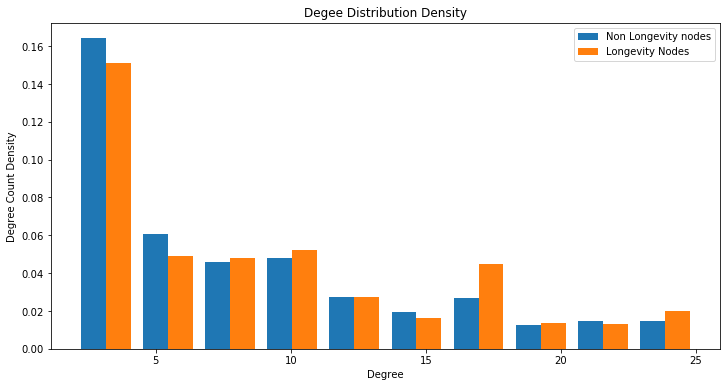

In [88]:
n_gl = []
l_gl = []

for n in non_longevity_nodes:
        x = G_main.degree(n)
        if x <= 25 and x> 1:
            n_gl.append(x)

for n in overall_longevity_nodes:
        x = G_main.degree(n)
        if x <= 25 and x >1 :
            l_gl.append(x)
        
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist([n_gl, l_gl], bins=10, density=True, label=['Non Longevity nodes', 'Longevity Nodes'])
ax.set_ylabel('Degree Count Density')
ax.set_xlabel('Degree')
ax.set_title('Degee Distribution Density')
ax.legend()

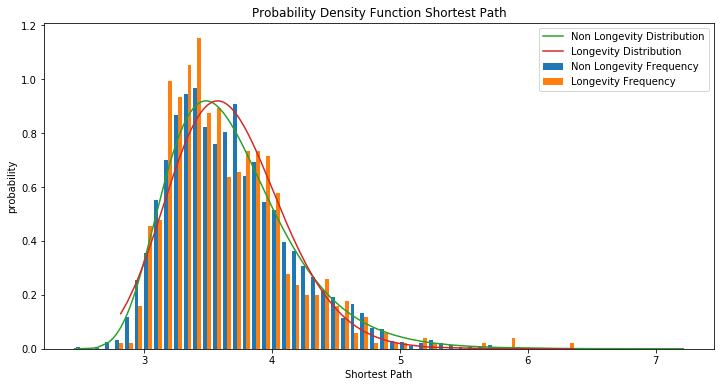

In [19]:
n_el = [single_source(G_main, n) for n in non_longevity_nodes]
l_el = [single_source(G_main, n) for n in overall_longevity_nodes]

nshape, nloc, nscale = stats.lognorm.fit(sorted(n_el), loc=0)
npdf_lognorm = stats.lognorm.pdf(sorted(n_el), nshape, nloc, nscale)

shape, loc, scale = stats.lognorm.fit(sorted(l_el), loc=0)
pdf_lognorm = stats.lognorm.pdf(sorted(l_el), shape, loc, scale)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist([n_el, l_el], bins='auto', density=True, label=['Non Longevity Frequency', 'Longevity Frequency'])
ax.plot(sorted(n_el), npdf_lognorm, label='Non Longevity Distribution')
ax.plot(sorted(l_el), pdf_lognorm, label = 'Longevity Distribution')
ax.set_ylabel('probability')
ax.set_xlabel('Shortest Path')
ax.set_title('Probability Density Function Shortest Path')
ax.legend()

In [20]:
z = {x: G.nodes[x]['chromosome'] for x in G.nodes()}
pairs = {i: [calculate_Participation(G, z, i), calculate_DegreezScore(G, i)] for i in G.nodes()}


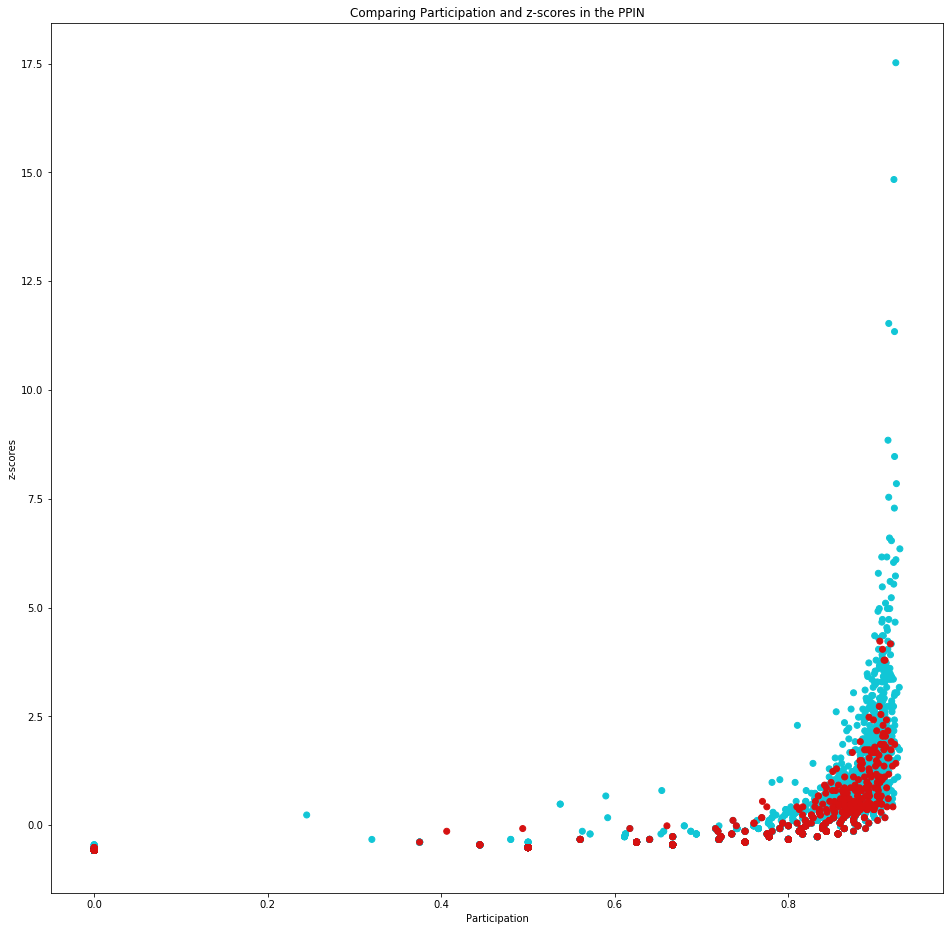

In [21]:
def make_scatter(pairs):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(111) # put multiple
    plt.scatter([pairs[n][0] for n in non_longevity_nodes],
                [pairs[n][1] for n in non_longevity_nodes],
                color=[G_main.nodes[x]['color'] for x in non_longevity_nodes])  # plot the S(t) time series
    
    plt.scatter([pairs[n][0] for n in overall_longevity_nodes],
                [pairs[n][1] for n in overall_longevity_nodes],
                color=['#d61111' for x in overall_longevity_nodes])  # plot the S(t) time series
    plt.ylabel('z-scores')
    plt.xlabel('Participation')
    plt.title('Comparing Participation and z-scores in the PPIN')
    plt.show()
    
make_scatter(pairs)

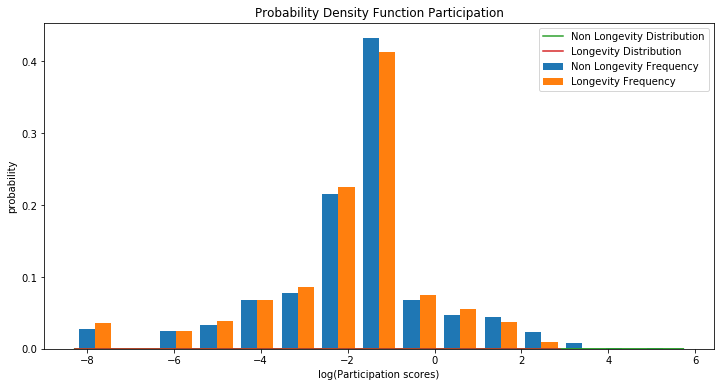

In [22]:
n_participation = [np.log(pairs[i][1]**2) for i in non_longevity_nodes]
l_participation = [np.log(pairs[i][1]**2) for i in overall_longevity_nodes]

nshape, nloc, nscale = stats.lognorm.fit(sorted(n_participation), loc=0)
npdf_lognorm = stats.lognorm.pdf(sorted(n_participation), nshape, nloc, nscale)

shape, loc, scale = stats.lognorm.fit(sorted(l_participation), loc=0)
pdf_lognorm = stats.lognorm.pdf(sorted(l_participation), shape, loc, scale)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist([n_participation, l_participation], bins=15, 
        density=True, label=['Non Longevity Frequency', 'Longevity Frequency'])
ax.plot(sorted(n_participation), npdf_lognorm, label='Non Longevity Distribution')
ax.plot(sorted(l_participation), pdf_lognorm, label = 'Longevity Distribution')
ax.set_ylabel('probability')
ax.set_xlabel('log(Participation scores)')
ax.set_title('Probability Density Function Participation')
ax.legend()

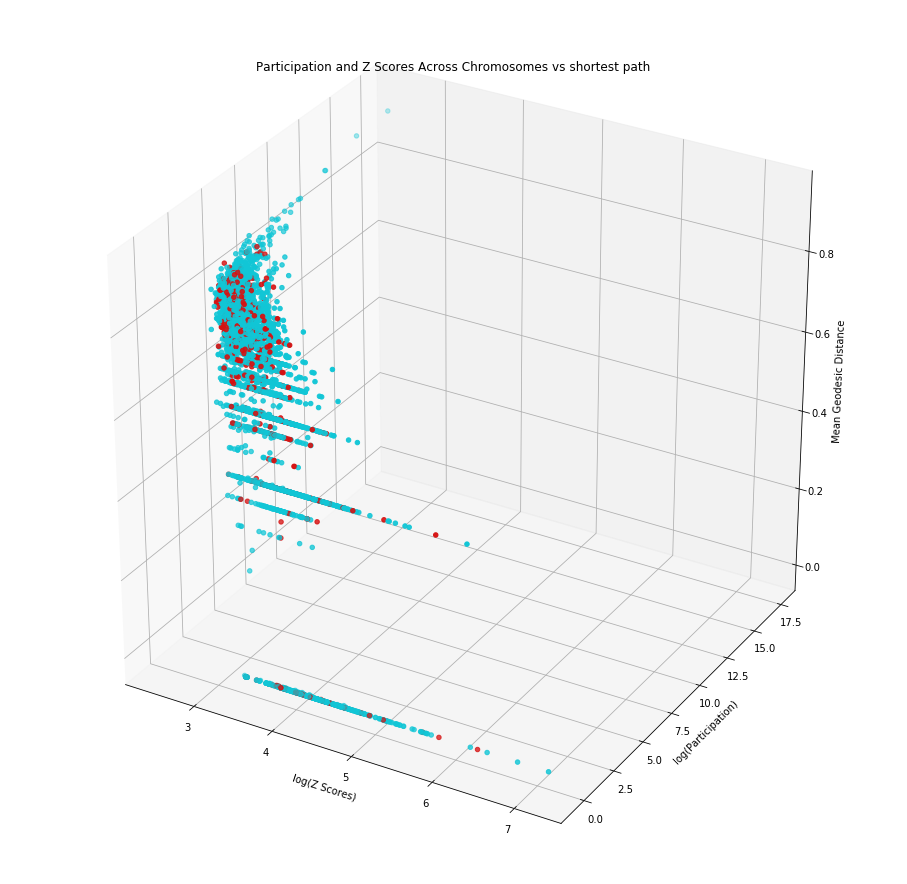

In [69]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.array([pairs[n][0] for n in G_main.nodes()])
Y = np.array([pairs[n][1] for n in G_main.nodes()])
Z = np.array([single_source(G_main, n) for n in G_main.nodes()])

colors = [G_main.nodes[n]['color'] for n in G_main.nodes()]

# Plot the surface.
bar = ax.scatter(Z, Y, X, color=colors)
ax.set_ylabel('log(Participation)')
ax.set_xlabel('log(Z Scores)')
ax.set_zlabel('Mean Geodesic Distance')


ax.set_title('Participation and Z Scores Across Chromosomes vs shortest path')
plt.show()

c:\users\jade\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


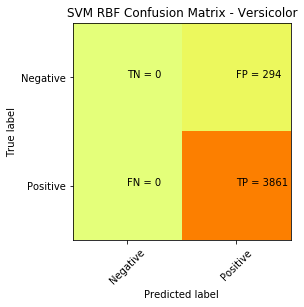

In [71]:
x = [[pairs[n][0], pairs[n][1]] for n in G_main.nodes()]
#x = [[G_main.nodes[n]['gene_length'], G_main.degree(n), pairs[n][0], pairs[n][1]] for n in G_main.nodes()]
#x = [[G.nodes[n]['gene_length'], G.degree(n)] for n in G.nodes()]
#x = [[G_main.degree(n), single_source(G_main, n)] for n in G_main.nodes()]
y = [G_main.nodes[n]['color'] == '#11c6d6' for n in G_main.nodes()]

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#x = sc.fit_transform(x)
#x_test = sc.fit_transform(x_test)
 
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=0)
svm.fit(x, y)
 
predicted = svm.predict(x_test)
 
cm = confusion_matrix(y_test, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM RBF Confusion Matrix - Versicolor')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

c:\users\jade\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


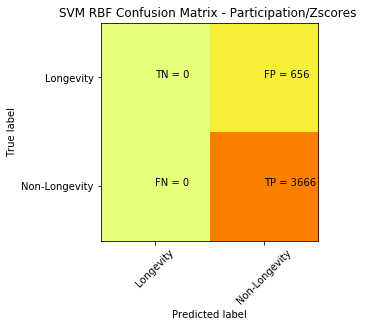

In [72]:
x = [[pairs[n][0], pairs[n][1]] for n in G_main.nodes()]
#x = [[G_main.nodes[n]['gene_length'], G_main.degree(n), pairs[n][0], pairs[n][1]] for n in G_main.nodes()]
#x = [[G.nodes[n]['gene_length'], G.degree(n)] for n in G.nodes()]
#x = [[G_main.degree(n), single_source(G_main, n)] for n in G_main.nodes()]
y = [G_main.nodes[n]['color'] == '#11c6d6' for n in G_main.nodes()]

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#x = sc.fit_transform(x)
#x_test = sc.fit_transform(x)
 
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=0)
svm.fit(x_test, y_test)
 
predicted = svm.predict(x)
 
cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Longevity','Non-Longevity']
plt.title('SVM RBF Confusion Matrix - Participation/Zscores ')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

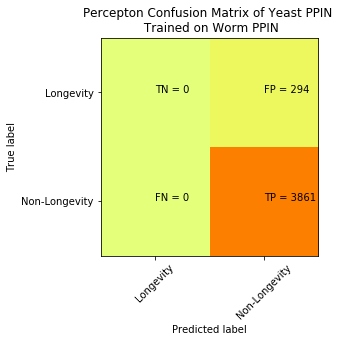

In [73]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(random_state = 0)
perceptron.fit(x, y)
predicted = perceptron.predict(x_test)

cm = confusion_matrix(y_test, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Longevity','Non-Longevity']
plt.title('Percepton Confusion Matrix of Yeast PPIN \n Trained on Worm PPIN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

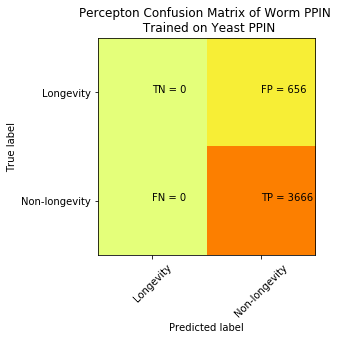

In [74]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(random_state = 0)
perceptron.fit(x_test, y_test)
predicted = perceptron.predict(x)

cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Longevity','Non-longevity']
plt.title('Percepton Confusion Matrix of Worm PPIN \n Trained on Yeast PPIN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

[(2, 5), (5, 2), (2, 1)]

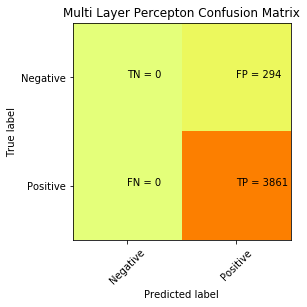

In [75]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x, y)
predicted = clf.predict(x_test)
cm = confusion_matrix(y_test, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Multi Layer Percepton Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
[coef.shape for coef in clf.coefs_]


[(2, 5), (5, 2), (2, 1)]

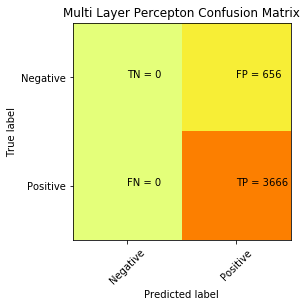

In [76]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x_test, y_test)
predicted = clf.predict(x)
cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Multi Layer Percepton Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
[coef.shape for coef in clf.coefs_]


[(2, 5), (5, 2), (2, 1)]

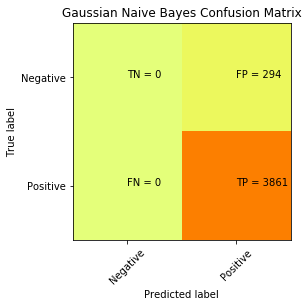

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
x = [[float(G_main.nodes[n]['gene_length']), G_main.degree(n), pairs[n][0], pairs[n][1]] for n in G_main.nodes()]
x_test = [[float(G_wmain.nodes[n]['gene_length']), G_wmain.degree(n), wpairs[n][0], wpairs[n][1]] for n in G_wmain.nodes()]


gnb = GaussianNB()
predicted = gnb.fit(x, y).predict(x_test)
cm = confusion_matrix(y_test, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
[coef.shape for coef in clf.coefs_]


[(2, 5), (5, 2), (2, 1)]

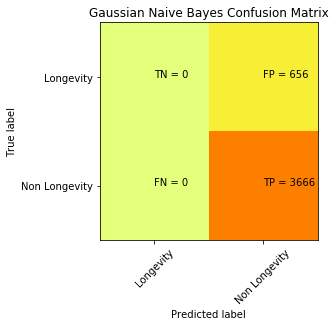

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
predicted = gnb.fit(x_test, y_test).predict(x)
cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Longevity','Non Longevity']
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
[coef.shape for coef in clf.coefs_]


In [42]:
#class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)[source]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit



C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-9, 1, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=10)
grid.fit(x, y)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.01, gamma=1e-09, score=0.849, total=   0.3s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.849, total=   0.3s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.849, total=   0.3s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.849, total=   0.3s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.849, total=   0.3s
[CV] C=0.01, gamma=3.162277660168379e-07 .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


[CV] . C=0.01, gamma=3.162277660168379e-07, score=0.849, total=   0.3s
[CV] C=0.01, gamma=3.162277660168379e-07 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


[CV] . C=0.01, gamma=3.162277660168379e-07, score=0.849, total=   0.3s
[CV] C=0.01, gamma=3.162277660168379e-07 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


[CV] . C=0.01, gamma=3.162277660168379e-07, score=0.849, total=   0.3s
[CV] C=0.01, gamma=3.162277660168379e-07 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


[CV] . C=0.01, gamma=3.162277660168379e-07, score=0.849, total=   0.3s
[CV] C=0.01, gamma=3.162277660168379e-07 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


[CV] . C=0.01, gamma=3.162277660168379e-07, score=0.849, total=   0.3s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.849, total=   0.8s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.849, total=   0.8s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.849, total=   0.8s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.849, total=   0.8s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.849, total=   0.8s
[CV] C=0.01, gamma=0.03162277660168379 ...............................
[CV] ... C=0.01, gamma=0.03162277660168379, score=0.849, total=   1.2s
[CV] C=0.01, gamma=0.03162277660168379 ...............................
[CV] .

[CV] .... C=1.0, gamma=0.03162277660168379, score=0.846, total=   1.5s
[CV] C=1.0, gamma=0.03162277660168379 ................................
[CV] .... C=1.0, gamma=0.03162277660168379, score=0.844, total=   1.5s
[CV] C=1.0, gamma=0.03162277660168379 ................................
[CV] .... C=1.0, gamma=0.03162277660168379, score=0.836, total=   1.5s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................... C=1.0, gamma=10.0, score=0.832, total=   1.7s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................... C=1.0, gamma=10.0, score=0.830, total=   1.8s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................... C=1.0, gamma=10.0, score=0.839, total=   1.7s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................... C=1.0, gamma=10.0, score=0.840, total=   1.7s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.00000000e-09, 3.16227766e-07, 1.00000000e-04, 3.16227766e-02,
       1.00000000e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

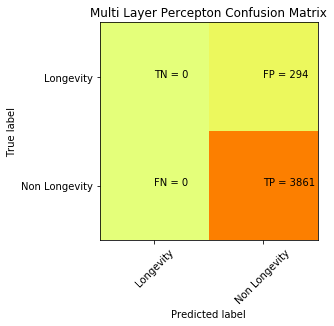

In [87]:

predicted = grid.predict(x_test)
cm = confusion_matrix(y_test, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Longevity','Non Longevity']
plt.title('Multi Layer Percepton Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))


In [63]:
#class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)[source]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit



C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-9, 1, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, verbose=10)
grid.fit(x_test, y_test)


NameError: name 'LogisticRegression' is not defined

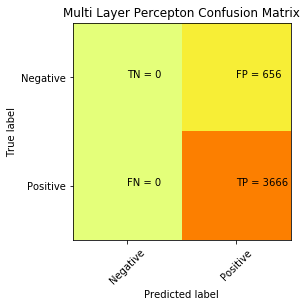

In [45]:

predicted = grid.predict(x)
cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Multi Layer Percepton Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))


In [25]:
worm_file = 'worm_genage_models_export.tsv'
homologous_files = ['genage_models_orthologs_export.tsv']#, 'worm_genage_models_orthologs_export.tsv',
                    #'fly_genage_models_orthologs_export.tsv', 'mouse_genage_models_orthologs_export.tsv']
df_worm = pd.read_csv(worm_file, sep=r'\t', engine='python')
wlongevity_id = [x for x in df_worm['Ensembl ID']]
wlongevity_method = [x for x in df_worm['Method']]
#print(longevity_method)
wlongevity_id_dict = dict(zip(wlongevity_id, wlongevity_method))

In [26]:
#Make graph with color coded nodes 
def set_color(n, wlongevity_id_dict):
    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc']
    #if n in del_list:
    if n in wlongevity_id_dict:
        #if longevity_id_dict[n] == 'pro':
        #    # green
        #return colors[1]
        #elif longevity_id_dict[n] == 'anti':
        #    # red
            return colors[0]
        #elif longevity_id_dict[n] == 'fitness':
        #    # orange
        #    return colors[3]
        #elif longevity_id_dict[n] == 'unclear':
        #    return colors[2]
        #else:
        #    return colors[2]
    else:
        return colors[2]
# Ohnologs = gene pairs within the same genome that were produced as the result of a whole genome 

In [27]:
G_w = nx.Graph()
        
wgene_quick_lookup = {} 
id_int = 0

with open('interolog.txt', 'r') as f:
    for line in f:
        #if id_int < 2000:
        i = line.split('\t')
        if '#' in i[0]:
            continue
        else:
            if i[0].strip() not in wgene_quick_lookup:
                wgene_quick_lookup[i[0].strip()] = id_int
                node_color = set_color(i[0].strip(), wlongevity_id_dict)
                G_w.add_node(id_int, name=i[0].strip(), color=node_color)
                id_int +=1
            if i[1].strip() not in wgene_quick_lookup:
                wgene_quick_lookup[i[1].strip()] = id_int
                node_color = set_color(i[1].strip() ,wlongevity_id_dict)
                G_w.add_node(id_int, name=i[1].strip(), color = node_color)
                id_int +=1
            G_w.add_edge(wgene_quick_lookup[i[0].strip()], wgene_quick_lookup[i[1].strip()])

In [28]:


with open('C_elgens.xls', 'r') as f:
    for line in f:
        #if id_int < 2000:
        i = line.split('\t')
        if ' ' in i[0] or i[0] == '\n':
            continue
        else:
            if i[0].strip() not in wgene_quick_lookup:
                wgene_quick_lookup[i[0].strip()] = id_int
                node_color = set_color(i[0].strip(), wlongevity_id_dict)
                G_w.add_node(id_int, name=i[0].strip(), color=node_color)
                id_int +=1
            if i[2].strip() not in wgene_quick_lookup:
                wgene_quick_lookup[i[2].strip()] = id_int
                node_color = set_color(i[2].strip(), wlongevity_id_dict)
                G_w.add_node(id_int, name=i[2].strip(), color = node_color)
                id_int +=1
            G_w.add_edge(wgene_quick_lookup[i[0].strip()], wgene_quick_lookup[i[2].strip()])

In [29]:
count = 0
with open('uniprot-proteome_UP000001940.tab', 'r') as f:
    for line in f:
        row = line.split()
        if count <= 3883:
            chrom = 'chrI'
        elif count <= 8348:
            chrom = 'chrII'
        elif count <= 11777:
            chrom = 'chrIII'
        elif count <= 16635:
            chrom = 'chrIV'
        elif count <= 23135:
            chrom = 'chrV'
        elif count <= 26850:
            chrom = 'chrx'
        else:
            chrom = 'Mitochondria'
        for x in row:
            if x in wgene_quick_lookup:
                G_w.nodes[wgene_quick_lookup[x]].update({'chromosome': chrom, 'gene_length': row[-1]})
        count +=1
print(count)

26851


In [30]:
for n in G_w.nodes():
    if 'color' not in G_w.nodes[n]:
        G_w.nodes[n]['color'] = set_color(G_w.nodes[n]['name'], wlongevity_id)
    if 'chromosome' not in G_w.nodes[n]:
        G_w.nodes[n].update({'chromosome': 'unk', 'gene_length':0})
        
    print(G_w.nodes[n])
connected = [c for c in sorted(nx.connected_components(G_w), key=len, reverse=True)]
G_wmain = G_w.subgraph(connected[0]).copy()

{'name': '4R79.1', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '180'}
{'name': 'C34D4.9', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '403'}
{'name': 'F39D8.4', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '450'}
{'name': 'AC3.3', 'color': '#11c6d6', 'chromosome': 'chrIII', 'gene_length': '425'}
{'name': 'C04E12.7', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '251'}
{'name': 'T22H2.5', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '289'}
{'name': 'Y55F3AM.14', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '662'}
{'name': 'ZK1053.5', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '265'}
{'name': 'AC3.4', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '425'}
{'name': 'AC3.6', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '325'}
{'name': 'C07H6.5', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '430'}
{'name': 'C47E8.5', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length

{'name': 'Y51A2A.1', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '227'}
{'name': 'Y52B11A.5', 'color': '#11c6d6', 'chromosome': 'chrIV', 'gene_length': '219'}
{'name': 'Y53H1A.3', 'color': '#11c6d6', 'chromosome': 'chrx', 'gene_length': '201'}
{'name': 'Y59H11AR.5', 'color': '#11c6d6', 'chromosome': 'chrIV', 'gene_length': '194'}
{'name': 'Y68A4B.1', 'color': '#11c6d6', 'chromosome': 'chrIV', 'gene_length': '177'}
{'name': 'Y68A4B.2', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '209'}
{'name': 'ZK39.2', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '229'}
{'name': 'ZK39.3', 'color': '#11c6d6', 'chromosome': 'chrIV', 'gene_length': '213'}
{'name': 'ZK39.4', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '222'}
{'name': 'ZK39.5', 'color': '#11c6d6', 'chromosome': 'chrIII', 'gene_length': '189'}
{'name': 'ZK39.6', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '192'}
{'name': 'ZK39.7', 'color': '#11c6d6', 'chromosome': 'chrII', 'g

{'name': 'T05B11.3', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '226'}
{'name': 'T25G3.4', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '722'}
{'name': 'T05G5.10', 'color': '#d61111', 'chromosome': 'chrx', 'gene_length': '66'}
{'name': 'T20F10.1', 'color': '#d61111', 'chromosome': 'chrII', 'gene_length': '908'}
{'name': 'Y43C5A.5', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '269'}
{'name': 'T12A2.15', 'color': '#11c6d6', 'chromosome': 'chrx', 'gene_length': '222'}
{'name': 'T06C12.10', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '466'}
{'name': 'T06H11.4', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '435'}
{'name': 'T07A9.11', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '131'}
{'name': 'W09C5.1', 'color': '#11c6d6', 'chromosome': 'chrx', 'gene_length': '259'}
{'name': 'T07C12.11', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '329'}
{'name': 'T08D10.1', 'color': '#11c6d6', 'chromosome': 'chrIII'

{'name': 'D1022.4', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '243'}
{'name': 'D1053.1', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '214'}
{'name': 'ZK829.7', 'color': '#11c6d6', 'chromosome': 'chrIII', 'gene_length': '372'}
{'name': 'D1054.13', 'color': '#11c6d6', 'chromosome': 'chrI', 'gene_length': '481'}
{'name': 'F08G12.4', 'color': '#d61111', 'chromosome': 'chrI', 'gene_length': '174'}
{'name': 'R166.1', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '582'}
{'name': 'D1081.9', 'color': '#11c6d6', 'chromosome': 'chrII', 'gene_length': '240'}
{'name': 'F55A12.10', 'color': '#11c6d6', 'chromosome': 'chrV', 'gene_length': '220'}
{'name': 'D2092.1', 'color': '#11c6d6', 'chromosome': 'chrx', 'gene_length': '736'}
{'name': 'Y71F9B.3', 'color': '#11c6d6', 'chromosome': 'chrIV', 'gene_length': '183'}
{'name': 'ZK40.1', 'color': '#11c6d6', 'chromosome': 'chrIII', 'gene_length': '399'}
{'name': 'D2013.6', 'color': '#11c6d6', 'chromosome': 'chrII', 'ge

In [31]:

wz = {x: G_wmain.nodes[x]['chromosome'] for x in G_wmain.nodes()}
wpairs = {i: [calculate_Participation(G_wmain, wz, i), calculate_DegreezScore(G_wmain, i)] for i in G_wmain.nodes()}

In [52]:
x_test = [[wpairs[n][0], wpairs[n][1]] for n in G_wmain.nodes()]

#x_test = [[G_wmain.nodes[n]['gene_length'], G_wmain.degree(n), wpairs[n][0], wpairs[n][1]] for n in G_wmain.nodes()]
y_test = [G_wmain.nodes[n]['color'] == '#11c6d6' for n in G_wmain.nodes()]
print(y_test)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False,

In [97]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x, y)
base_accuracy = evaluate(base_model, x, y)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.1030 degrees.
Accuracy = nan%.
Model Performance
Average Error: 0.1997 degrees.
Accuracy = -inf%.
Improvement of nan%.


c:\users\jade\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
c:\users\jade\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
c:\users\jade\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [226]:
def comparitive_pdf(G, z, node_dict):
    fig, ax = plt.subplots(figsize=(12, 12))
    for l in node_dict:
        node_dict[l]['vals'] = []
        for n in node_dict[l]['nodes']:
            try:
                #x= calculate_Participation(G_main,z,n)
                x =calculate_DegreezScore(G_main, i)
                #x = np.log(G_main.nodes[n]['gene_length'])
                #x = G_main.nodes[n]['gene_length']
                #x = single_source(G_main, n)
                #x = np.log(single_source(G_main,n))
                node_dict[l]['vals'].append(x)
            except: 
                continue

        shape, loc, scale = stats.lognorm.fit(sorted(node_dict[l]['vals']), loc=0)
        pdf_lognorm = stats.lognorm.pdf(sorted(node_dict[l]['vals']), shape, loc, scale)
        node_dict[l]['pdf'] = pdf_lognorm
        ax.plot(sorted(node_dict[l]['vals']), pdf_lognorm, label=node_dict[l]['label'], color=node_dict[l]['color'])

    ax.hist([node_dict[x]['vals'] for x in node_dict],
            bins=5, density=True, label=[node_dict[x]['label'] for x in node_dict],
            color=[node_dict[x]['color'] for x in node_dict])
    ax.set_ylabel('probability')
    ax.set_xlabel('Shortest Path')
    ax.set_title('Probability Density Function Shortest Path')
    ax.legend()

In [95]:
def get_stats(G, color):
    longevity_nodes = [n for n in G.nodes if G_main.nodes[n]['color'] == color]
    edges = 0
    for n in longevity_nodes:
        edges += G.degree(n)
    
    ell = 0 
    for n in longevity_nodes:
        ell += single_source(G, n)
    ellmean = ell/len(longevity_nodes)
    
    zscore = []
    avg_gene_length = []
    for i in longevity_nodes:
        try:
            avg_gene_length.append(int(G_main.nodes[i]['gene_length']))
        except:
            continue
        zscore.append(calculate_DegreezScore(G_main, i))
    zscore_std = np.std(zscore)
    mean_zscore = np.mean(zscore)
    gl_std = np.std(avg_gene_length)
    mean_gl = np.mean(avg_gene_length)
    return longevity_nodes, edges, ellmean, zscore_std, mean_zscore, gl_std, mean_gl


In [26]:
pro_nodes, edges, ellmean, zscore_std, mean_zscore, pro_glstd, pro_meangl = get_stats(G_main, '#11d646')
print("Pro Longevity Nodes")
print("Number of Nodes: {}".format(len(pro_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(pro_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(pro_meangl))
node_dict = {'non_longevity': {'nodes':non_longevity_nodes, 'label': 'Non Longevity', 'color': '#d61111'},
             'pro_longevity': {'nodes': pro_nodes, 'label': 'Pro Longevity', 'color': '#11d646'}}
comparitive_pdf(G_main, z, node_dict)

ZeroDivisionError: division by zero

In [ ]:
anti_nodes, edges, ellmean, zscore_std, mean_zscore, anti_glstd, anti_meangl = get_stats(G_main, '#d61111')
print("Anti Longevity Nodes")
print("Number of Nodes: {}".format(len(anti_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(anti_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(anti_meangl))
node_dict = {'anti_longevity': {'nodes': anti_nodes, 'label': 'Anti Longevity', 'color': '#d61111'},
             'pro_longevity': {'nodes': pro_nodes, 'label': 'Pro Longevity', 'color': '#11d646'}}
comparitive_pdf(G_main, z, node_dict)

#comparitive_pdf(non_longevity_nodes, anti_nodes, ['Non Longevity', 'Anti Longevity'])
#comparitive_pdf(pro_nodes, anti_nodes, ['Pro Longevity', 'Anti Longevity'])

In [ ]:
fit_nodes, edges, ellmean, zscore_std, mean_zscore, fit_glstd, fit_meangl = get_stats(G_main, '#d67711')
print("Fitness Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(fit_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(fit_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))
print('Avg gene length of {}'.format(fit_meangl))

node_dict = {'anti_longevity': {'nodes': anti_nodes, 'label': 'Anti Longevity', 'color': '#d61111'},
             'pro_longevity': {'nodes': pro_nodes, 'label': 'Pro Longevity', 'color': '#11d646'},
             'fit_longevity': {'nodes': fit_nodes, 'label': 'Fit Longevity', 'color': '#d67711'}}
comparitive_pdf(G_main, z, node_dict)

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Degree spread')
ax.scatter([np.log(single_source(G_main, n)) for n in non_longevity_nodes],
           [np.log(G_main.degree(n)) for n in non_longevity_nodes],
            color='#11c6d6', label='non longevity')
ax.scatter([np.log(single_source(G_main, n)) for n in fit_nodes],
           [np.log(G_main.degree(n)) for n in fit_nodes],
            color='#d67711', label='fitness')
ax.scatter([np.log(single_source(G_main, n)) for n in anti_nodes],
           [np.log(G_main.degree(n)) for n in anti_nodes],
            color='#d61111', label='anti Longevity')
ax.scatter([np.log(single_source(G_main, n)) for n in pro_nodes],
           [np.log(G_main.degree(n)) for n in pro_nodes],
            color='#11d646', label='pro Longevity')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Average Shortest Path')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[single_source(G_main, n) for n in non_longevity_nodes],
          [single_source(G_main, n) for n in fit_nodes],
          [single_source(G_main, n) for n in anti_nodes],
          [single_source(G_main, n) for n in pro_nodes]],
         bins=13, label=labels, color=colors, density=True, stacked=False)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Degree spread')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[np.log(G_main.degree(n)) for n in non_longevity_nodes],
          [np.log(G_main.degree(n)) for n in fit_nodes],
          [np.log(G_main.degree(n)) for n in anti_nodes],
          [np.log(G_main.degree(n)) for n in pro_nodes]],
         bins=6,color=colors, label=labels, density=True)
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Average Shortest Path')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[np.log(calculate_DegreezScore(G_main, n)) for n in non_longevity_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in fit_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in anti_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in pro_nodes]],
         bins=5, label=labels, color=colors, density=True, stacked=False)
ax.legend()
fig.tight_layout()
plt.show()

In [51]:
def calculate_Participation(G,z,i):
    # This function calculates the participation coefficient of node i, given graph G and partition z
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes
    #        : i, a node in G
    # output : P_i, the participation coefficient
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 9 lines, plus return)
    
    groups = {}
    sum_val = 0
    for n in G.neighbors(i):
        if z[n] not in groups:
            groups[z[n]] = 1
        else:
            groups[z[n]] +=1
    for g in groups:
        sum_val += (groups[g]/G.degree(i))**2
    return 1- sum_val
z = {x: G_main.nodes[x]['chromosome'] for x in G_main.nodes()}

In [52]:
z = {x: G_main.nodes[x]['chromosome'] for x in G_main.nodes()}
pairs = {i: [calculate_Participation(G_main, z, i), calculate_DegreezScore(G_main, i)] for i in G_main.nodes()}

In [53]:
n_participation = []
l_participation = []

for n in non_longevity_nodes:
    n_participation.append(z[n][0])

for n in overall_longevity_nodes:
    l_participation.append(z[n][0])
nshape, nloc, nscale = stats.lognorm.fit(sorted(n_gle), loc=0)
npdf_lognorm = stats.lognorm.pdf(sorted(n_gle), nshape, nloc, nscale)

shape, loc, scale = stats.lognorm.fit(sorted(l_gle), loc=0)
pdf_lognorm = stats.lognorm.pdf(sorted(l_gle), shape, loc, scale)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist([n_gle, l_gle], bins='auto', density=True)
ax.plot(sorted(n_gle), npdf_lognorm, label='Non Longevity Distribution')
ax.plot(sorted(l_gle), pdf_lognorm, label = 'Longevity Distribution')
ax.set_ylabel('probability')
ax.set_xlabel('Zscore')
ax.set_title('Probability Density Function Zscore')
ax.legend()

NameError: name 'n_gle' is not defined

In [24]:



n_Z = [(pairs[n][0]**2)*G_main.nodes[n]['gene_length'] for n in non_longevity_nodes]
l_Z = [(pairs[n][0]**2)*G_main.nodes[n]['gene_length'] for n in overall_longevity_nodes]

nshape, nloc, nscale = stats.lognorm.fit(sorted(n_Z), loc=0)
npdf_lognorm = stats.lognorm.pdf(sorted(n_Z), nshape, nloc, nscale)

shape, loc, scale = stats.lognorm.fit(sorted(l_Z), loc=0)
pdf_lognorm = stats.lognorm.pdf(sorted(l_Z), shape, loc, scale)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist([n_Z, l_Z], bins='auto', density=True)
ax.plot(sorted(n_Z), npdf_lognorm)
ax.plot(sorted(l_Z), pdf_lognorm)
ax.set_ylabel('probability')
ax.set_xlabel('Z_scores')
ax.set_title('Probability Density Function Z-Scores Non Longevity Nodes')


KeyError: 'gene_length'

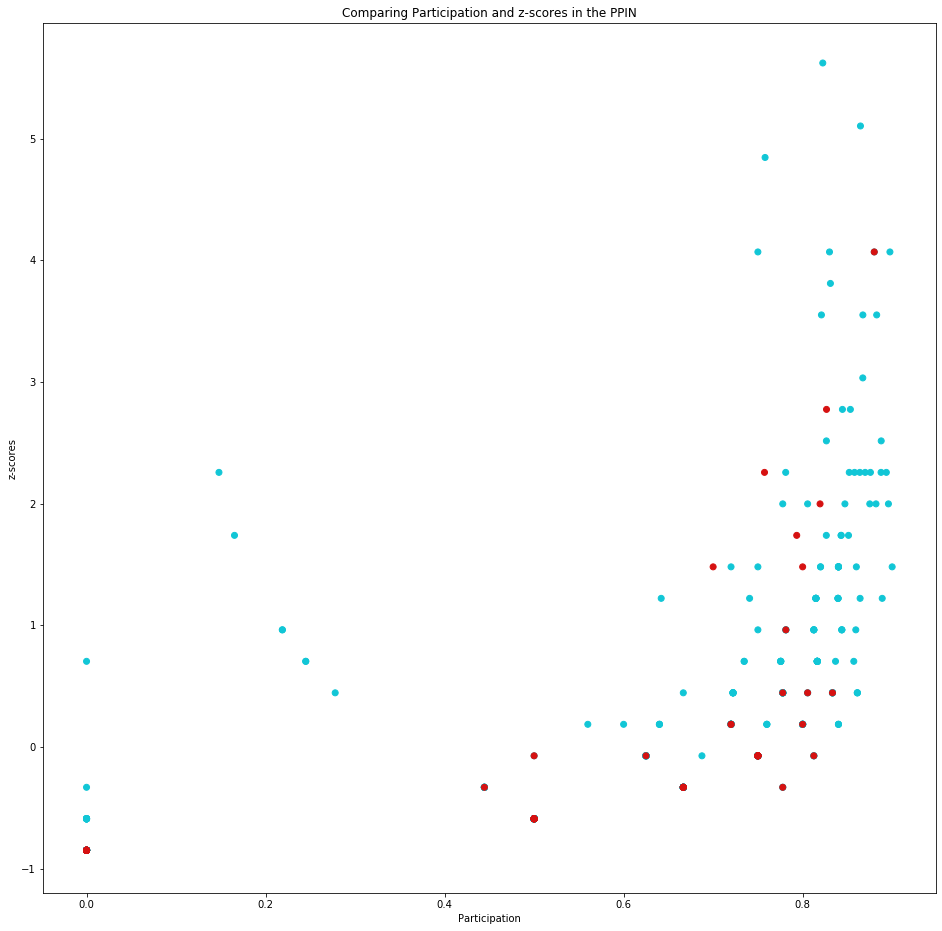

In [54]:
def make_scatter(pairs):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(111) # put multiple
    plt.scatter([pairs[n][0] for n in non_longevity_nodes],
                [pairs[n][1] for n in non_longevity_nodes],
                color=[G_main.nodes[x]['color'] for x in non_longevity_nodes])  # plot the S(t) time series
    
    plt.scatter([pairs[n][0] for n in overall_longevity_nodes],
                [pairs[n][1] for n in overall_longevity_nodes],
                color=['#d61111' for x in overall_longevity_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in fit_nodes],
    #            [pairs[n][1] for n in fit_nodes],
    #            color=[G_main.nodes[x]['color'] for x in fit_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in anti_nodes],
    #            [pairs[n][1] for n in anti_nodes],
    #            color=[G_main.nodes[x]['color'] for x in anti_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in pro_nodes],
    #            [pairs[n][1] for n in pro_nodes],
    #            color=[G_main.nodes[x]['color'] for x in pro_nodes])  # plot the S(t) time series
    plt.ylabel('z-scores')
    plt.xlabel('Participation')
    plt.title('Comparing Participation and z-scores in the PPIN')
    plt.show()
    
make_scatter(pairs)

In [30]:
worm_file = 'worm_genage_models_export.tsv'
df_worm = pd.read_csv(worm_file, sep=r'\t', engine='python')
df_worm.head(20)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,Could be a sensor that couples energy levels a...,pro,NaN,12.0,Knockout,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
1,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,37% decrease in median lifespna in daf-2 backg...,pro,NaN,54.0,RNA interference,"2239: Samuelson et al. (2007) ""Gene activities..."
2,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4423: Burkewitz et al. (2015) ""Neuronal CRTC-1..."
3,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increase,Transgenic animals with a higher aak-2 gene do...,pro,NaN,13.0,Overexpression,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
4,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,NaN,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
5,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
6,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
7,269,181492.0,aakb-1,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.860,F55F3.1,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
8,752,176552.0,aakb-2,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.9773,Y47D3A.15,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
9,1849,181736.0,aakg-2,Protein AAKG-2,Caenorhabditis elegans,NaN,NaN,NaN,NaN,increase,"aakg-2 overexpression extends mean, median, an...",pro,35,47.0,Overexpression,"2588: Sagi and Kim (2012) ""An engineering appr..."


In [53]:
mus_file = 'mus_genage_models_export.tsv'
df_mus = pd.read_csv(mus_file, sep=r'\t', engine='python')
df_mus.head(20)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,6,224129,Adcy5,adenylate cyclase 5,Mus musculus,Mm.41137,ENSMUSG00000022840,P84309,Ac5 AW121902,increase,Knock out mice are resistant to cardiac stress...,anti,12,30.0,Knockout,"1845: Yan et al. (2007) ""Type 5 adenylyl cycla..."
1,1953,11549,Adra1a,"adrenergic receptor, alpha 1a",Mus musculus,NaN,NaN,NaN,NaN,increase,Transgenic mice overexpressing a CAM form of t...,pro,8,10.0,Overexpression,"3541: Doze et al. (2011) ""Long-term Î±1A-adren..."
2,1954,11548,Adra1b,"adrenergic receptor, alpha 1b",Mus musculus,NaN,NaN,NaN,NaN,decrease,Transgenic mice overexpressing a CAM form of t...,anti,NaN,11.0,Overexpression,"3542: Collette et al. (2014) ""Long-term Î±1B-a..."
3,811,11607,Agtr1a,"Angiotensin II receptor, type 1a",Mus musculus,NaN,ENSMUSG00000049115,NaN,AT1 AG2S AT1a AT2R1 Agtr1 AT2R1A Agtr-1a AI551...,increase,KO mice showed a significant prolongation of a...,anti,24,26.0,Knockout,"2148: Benigni et al. (2009) ""Disruption of the..."
4,1810,11651,Akt1,thymoma viral proto-oncogene 1,Mus musculus,NaN,NaN,NaN,Akt PKB Rac PKB/Akt PKBalpha,increase,Haploinsufficient mice had a lower body weight...,anti,NaN,11.5,Genetic reduction,"3259: Nojima et al. (2013) ""Haploinsufficiency..."
5,2231,11652,Akt2,thymoma viral proto-oncogene 2,Mus musculus,NaN,NaN,NaN,NaN,increase,Akt2-/- mice exhibited a 9.1% increase in mean...,anti,NaN,9.0,Deletion,"4770: Ren et al. (2017) ""Akt2 ablation prolong..."
6,812,11816,Apoe,Apolipoprotein E,Mus musculus,NaN,ENSMUSG00000002985,NaN,AI255918,decrease,The mutant mice show dysregulations in lipid m...,pro,NaN,NaN,Knockout,"2138: Moghadasian et al. (2001) ""Pathophysiolo..."
7,13,228359,Arhgap1,Rho GTPase activating protein 1,Mus musculus,Mm.463444,ENSMUSG00000027247,Q5FWK3,C76222 Cdc42GAP p50rhoGAP RP23-12H6.2 B230365D...,decrease,Most knockout mice were weak and died during t...,pro,NaN,NaN,Knockout,"1840: Wang et al. (2007) ""Cdc42 GTPase-activat..."
8,15,11865,Arntl,aryl hydrocarbon receptor nuclear translocator...,Mus musculus,Mm.440371,ENSMUSG00000055116,Q9WTL8,MOP3 Arnt3 Bmal1 BMAL1b bHLHe5 bmal1b',decrease,Knockout mice display symptoms of premature ag...,pro,NaN,NaN,Knockout,"1841: Kondratov et al. (2006) ""Early aging and..."
9,1862,11793,Atg5,autophagy related 5,Mus musculus,NaN,NaN,NaN,NaN,increase,Overexpression of Atg5 extends median lifespan...,pro,NaN,17.0,Overexpression,"3492: Pyo et al. (2013) ""Overexpression of Atg..."
